In [ ]:
!pip install zarr torch torchvision lightning pandas tensorboard

In [ ]:
import os
import json
import zarr
import numpy as np
import math
from datetime import datetime
import copy
import random
import shutil
import pickle as pkl
from collections import defaultdict
from typing import List

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms import Compose, transforms

import torchmetrics
from torchmetrics import ConfusionMatrix, F1Score, Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix

In [ ]:
data_path = '/kaggle/input/parcels/2017'

In [ ]:
with open (os.path.join(data_path, 'meta/labels.json')) as l:
  labels = json.load(l)

In [ ]:
print(labels)
print(len(labels))

{'0': 'corn', '1': 'corn', '2': 'corn', '3': 'corn', '4': 'corn', '5': 'spring_barley', '6': 'corn', '7': 'corn', '8': 'corn', '9': 'meadow', '10': 'corn', '11': 'corn', '12': 'spring_barley', '13': 'corn', '14': 'corn', '15': 'corn', '16': 'corn', '17': 'corn', '18': 'corn', '19': 'corn', '20': 'corn', '21': 'corn', '22': 'meadow', '23': 'winter_wheat', '24': 'winter_rapeseed', '25': 'unknown', '26': 'winter_barley', '27': 'winter_barley', '28': 'winter_rye', '29': 'winter_rye', '30': 'winter_barley', '31': 'spring_barley', '32': 'spring_barley', '33': 'unknown', '34': 'unknown', '35': 'unknown', '36': 'unknown', '37': 'unknown', '38': 'unknown', '39': 'unknown', '40': 'unknown', '41': 'unknown', '42': 'winter_wheat', '43': 'meadow', '44': 'spring_barley', '45': 'winter_wheat', '46': 'winter_barley', '47': 'spring_barley', '48': 'spring_barley', '49': 'spring_barley', '50': 'spring_barley', '51': 'winter_rye', '52': 'winter_rye', '53': 'meadow', '54': 'spring_barley', '55': 'corn', '5

In [ ]:
category_counts = {}
for label in labels.values():
  if label not in category_counts:
    category_counts[label]=1
  else:
    category_counts[label]+=1

In [ ]:
for category, count in category_counts.items():
  print(f'Category: {category}, Count: {count}')

In [ ]:
print(category_counts)

{'corn': 275, 'spring_barley': 1141, 'meadow': 1013, 'winter_wheat': 856, 'winter_rapeseed': 301, 'unknown': 511, 'winter_barley': 352, 'winter_rye': 317, 'spring_peas': 17, 'spring_oat': 120, 'horsebeans': 28, 'winter_triticale': 42, 'spring_wheat': 26, 'spring_triticale': 2}


In [ ]:
filtered_labels = {}
zarr_to_exclude = []

for k, v in labels.items():
    if category_counts[v] > 200:
        filtered_labels[k] = v
    else:
        zarr_to_exclude.append(k)

print("Filtered Labels:")
print(filtered_labels)
print("Zarr to Exclude:")
print(zarr_to_exclude)

Filtered Labels:
{'0': 'corn', '1': 'corn', '2': 'corn', '3': 'corn', '4': 'corn', '5': 'spring_barley', '6': 'corn', '7': 'corn', '8': 'corn', '9': 'meadow', '10': 'corn', '11': 'corn', '12': 'spring_barley', '13': 'corn', '14': 'corn', '15': 'corn', '16': 'corn', '17': 'corn', '18': 'corn', '19': 'corn', '20': 'corn', '21': 'corn', '22': 'meadow', '23': 'winter_wheat', '24': 'winter_rapeseed', '25': 'unknown', '26': 'winter_barley', '27': 'winter_barley', '28': 'winter_rye', '29': 'winter_rye', '30': 'winter_barley', '31': 'spring_barley', '32': 'spring_barley', '33': 'unknown', '34': 'unknown', '35': 'unknown', '36': 'unknown', '37': 'unknown', '38': 'unknown', '39': 'unknown', '40': 'unknown', '41': 'unknown', '42': 'winter_wheat', '43': 'meadow', '44': 'spring_barley', '45': 'winter_wheat', '46': 'winter_barley', '47': 'spring_barley', '48': 'spring_barley', '49': 'spring_barley', '50': 'spring_barley', '51': 'winter_rye', '52': 'winter_rye', '53': 'meadow', '54': 'spring_barley',

In [ ]:
filtered_labels_ni = {}
for k, v in filtered_labels.items():
    if v == 'corn':
        filtered_labels_ni[v] = 0
    elif v == 'spring_barley':
        filtered_labels_ni[v] = 1
    elif v == 'meadow':
        filtered_labels_ni[v] = 2
    elif v == 'winter_wheat':
        filtered_labels_ni[v] = 3
    elif v == 'winter_rapeseed':
        filtered_labels_ni[v] = 4
    elif v == 'unknown':
        filtered_labels_ni[v] = 5
    elif v == 'winter_barley':
        filtered_labels_ni[v] = 6
    elif v == 'winter_rye':
        filtered_labels_ni[v] = 7


print(filtered_labels_ni)

{'corn': 0, 'spring_barley': 1, 'meadow': 2, 'winter_wheat': 3, 'winter_rapeseed': 4, 'unknown': 5, 'winter_barley': 6, 'winter_rye': 7}


In [ ]:
with open (os.path.join(data_path, 'meta/dates.json')) as d:
  dates = json.load(d)

In [ ]:
print(dates)
print(len(dates))

[20170113, 20170222, 20170301, 20170311, 20170321, 20170324, 20170403, 20170423, 20170430, 20170503, 20170513, 20170523, 20170602, 20170619, 20170622, 20170702, 20170704, 20170709, 20170712, 20170717, 20170719, 20170806, 20170808, 20170813, 20170816, 20170818, 20170821, 20170823, 20170826, 20170910, 20170912, 20170917, 20170920, 20170925, 20170927, 20171002, 20171012, 20171022, 20171025, 20171027, 20171030, 20171106, 20171114, 20171119, 20171121, 20171126, 20171129, 20171201, 20171209, 20171216, 20171219, 20171229]
52


In [ ]:
dates_str = []
for i in dates:
  dates_str.append(str(i))

In [ ]:
print(dates_str)

['20170113', '20170222', '20170301', '20170311', '20170321', '20170324', '20170403', '20170423', '20170430', '20170503', '20170513', '20170523', '20170602', '20170619', '20170622', '20170702', '20170704', '20170709', '20170712', '20170717', '20170719', '20170806', '20170808', '20170813', '20170816', '20170818', '20170821', '20170823', '20170826', '20170910', '20170912', '20170917', '20170920', '20170925', '20170927', '20171002', '20171012', '20171022', '20171025', '20171027', '20171030', '20171106', '20171114', '20171119', '20171121', '20171126', '20171129', '20171201', '20171209', '20171216', '20171219', '20171229']


In [ ]:
type(dates_str[0])

str

In [ ]:
def date_to_day_of_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    return (date_obj - datetime(2017, 1, 1)).days + 1

dates = [date_to_day_of_year(date) for date in dates_str]

In [ ]:
print(dates)
type(dates[0])

[13, 53, 60, 70, 80, 83, 93, 113, 120, 123, 133, 143, 153, 170, 173, 183, 185, 190, 193, 198, 200, 218, 220, 225, 228, 230, 233, 235, 238, 253, 255, 260, 263, 268, 270, 275, 285, 295, 298, 300, 303, 310, 318, 323, 325, 330, 333, 335, 343, 350, 353, 363]


int

In [ ]:
data_root = '/kaggle/input/parcels-final/data' #na ehw kanei filtrarisma

In [ ]:
labels_list = [filtered_labels_ni[label] for label in filtered_labels.values()]

print("Labels list:", labels_list)
print("Number of labels:", len(labels_list))

Labels list: [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 6, 7, 7, 6, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 2, 1, 3, 6, 1, 1, 1, 1, 7, 7, 2, 1, 0, 1, 7, 5, 1, 0, 1, 1, 5, 1, 7, 5, 6, 1, 1, 1, 7, 1, 0, 0, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 0, 5, 3, 3, 5, 5, 1, 5, 5, 5, 2, 1, 1, 1, 7, 4, 3, 2, 6, 6, 4, 4, 1, 1, 4, 3, 2, 1, 3, 5, 2, 3, 3, 3, 6, 4, 4, 1, 6, 5, 1, 1, 1, 1, 2, 3, 3, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 0, 0, 2, 7, 0, 6, 2, 0, 0, 7, 2, 2, 1, 1, 2, 1, 1, 1, 7, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 7, 0, 0, 1, 1, 7, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 7, 2, 1, 1, 1, 3, 7, 7, 7, 3, 1, 0, 0, 0, 5, 3, 3, 3, 1, 1, 3, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 2, 0, 0, 2, 5, 5, 2, 2, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 2, 2, 2, 5, 5, 5, 5, 5, 0, 5, 0, 0, 2, 4, 5, 0, 1, 4, 4, 3, 0, 2, 0, 3, 1, 0, 2, 1, 3, 3, 0, 0, 0, 3, 7, 3, 3, 0, 0, 0, 0, 2, 2, 2,

#Sampling και Normalization

In [ ]:
class RandomSamplePixels(object):
    """Randomly draw num_pixels from the available pixels in the data.
    If the total number of pixels is less than num_pixels, samples with replacement.

    Args:
        num_pixels (int): Number of pixels to sample.
    """

    def __init__(self, num_pixels):
        self.num_pixels = num_pixels

    def __call__(self, sample):
        data, label = sample
        T, C, S = data.shape
        if S > self.num_pixels:
            indices = random.sample(range(S), self.num_pixels)
            data = data[:, :, indices]
        else:
            indices = np.random.choice(S, self.num_pixels, replace=True)
            data = data[:, :, indices]
        return (data, label)

class Normalize(object):
    """Normalize by rescaling pixels to [0, 1]

    Args:
        max_pixel_value (int): Max value of pixels to move pixels to [0, 1]
    """

    def __init__(self, max_pixel_value=65535):
        self.max_pixel_value = max_pixel_value

    def __call__(self, sample):
        data, label = sample
        data = np.clip(data, 0, self.max_pixel_value).astype(np.float32) / self.max_pixel_value
        return (data, label)

class ToTensor(object):
    def __call__(self, sample):
        data, label = sample
        data = torch.from_numpy(data.astype(np.float32))
        label = torch.tensor(label).to(torch.int64)
        return (data, label)


#Dataset

In [ ]:
class PixelSetData(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.filtered_labels = filtered_labels
        self.filtered_labels_ni = filtered_labels_ni
        self.transform = transform
        self.parcel_idx = list(self.filtered_labels.keys())

    def __len__(self):
        return len(self.parcel_idx)

    def __getitem__(self, idx):
        parcel_id = self.parcel_idx[idx]
        label = self.filtered_labels_ni[self.filtered_labels[parcel_id]]

        #print(f"Parcel ID: {parcel_id}, Label: {label}")

        path = os.path.join(self.data_root, f'{parcel_id}.zarr')

        if not os.path.exists(path):
            print(f"File not found: {path}")
            raise FileNotFoundError(f"File not found: {path}")

        data = zarr.open(path, mode='r')[:]
        sample = (data, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
train_transforms = transforms.Compose([
    RandomSamplePixels(num_pixels=32),
    Normalize(max_pixel_value=65535),
    ToTensor(),
])

val_transforms = transforms.Compose([
    Normalize(max_pixel_value=65535),
    ToTensor(),
])

DATA_ROOT = '/kaggle/input/parcels-final/data'

In [ ]:
def pad_sequences_collate_fn(samples: List[tuple]) -> tuple:
    """
    Zero-pad (in front) each sample to enable batching. The longest sequence defines the sequence length for the batch.
    """

    labels = torch.stack([v[1].clone().detach() for v in samples])

    data_list = [v[0].clone().detach() for v in samples]

    max_length = max([data.size(-1) for data in data_list])

    padded_data_list = []
    for data in data_list:
        pad_size = max_length - data.size(-1)
        if pad_size > 0:
            padded_data = torch.nn.functional.pad(data, (0, pad_size))
        else:
            padded_data = data
        padded_data_list.append(padded_data)

    data = torch.stack(padded_data_list, dim=0)

    return data, labels

In [ ]:
train_dset = PixelSetData(DATA_ROOT, transform=train_transforms)
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

val_dset = PixelSetData(DATA_ROOT, transform=val_transforms)
val_loader = DataLoader(val_dset, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, collate_fn=pad_sequences_collate_fn)

In [ ]:
# # Check
# for data, labels in train_loader:
#     print(data.shape, labels.shape)
#     break

In [ ]:
# # Check
# for data, labels in val_loader:
#     print(data.shape, labels.shape)
#     print(labels)
#     break

#Pixel Set Encoder

In [ ]:
class PixelSetEncoder(nn.Module):
    def __init__(self, num_channels, inter_dim, out_dim):
        super(PixelSetEncoder, self).__init__()
        self.mlp1 = nn.Sequential(
            nn.Linear(num_channels, inter_dim),
            nn.BatchNorm1d(inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, inter_dim),
            nn.BatchNorm1d(inter_dim),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Linear(inter_dim * 2, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x):
        batch_size, num_pixels, num_channels = x.size()

        x = x.view(-1, num_channels)
        x = self.mlp1(x)

        x = x.view(batch_size, num_pixels, -1)

        x_mean = x.mean(dim=1)
        x_std = x.std(dim=1)

        x = torch.cat([x_mean, x_std], dim=1)

        x = self.mlp2(x)

        return x

#Positional Encoder

In [ ]:
def get_extended_dates_tensor(num_pixels, dates_list):
    dates_array = np.array(dates_list)
    dates_array = np.tile(dates_array, (num_pixels // len(dates_list) + 1))[:num_pixels]
    return torch.tensor(dates_array, dtype=torch.float32)

class PositionalEncoding(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.input_dim = input_dim
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def pos_emb(self, dates_tensor, dim):
        div_term = torch.exp(torch.arange(0, dim, 2).float().to(device) * (-math.log(10000.0) / dim))
        pe = torch.zeros(dates_tensor.size(0), dim)
        pe[:, 0::2] = torch.sin(dates_tensor.unsqueeze(-1) * div_term)
        pe[:, 1::2] = torch.cos(dates_tensor.unsqueeze(-1) * div_term)
        return pe

    def forward(self, x, dates_tensor):
        # x: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.size()
        dates_tensor = dates_tensor.to(x.device)
        pe = self.pos_emb(dates_tensor[:seq_len], self.input_dim).to(x.device)
        pe = pe.unsqueeze(0).expand(batch_size, -1, -1)

#         print(f"x shape: {x.shape}")
#         print(f"pe shape: {pe.shape}")

        x = x + pe
        x = self.encoder(x)
        return x[:, 0, :]

#Classifier

In [ ]:
class CLS(nn.Module):
    def __init__(self, entry, inter, num_classes):
        super(CLS, self).__init__()
        self.FC1 = nn.Linear(entry, inter)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.FC2 = nn.Linear(inter, num_classes)

    def forward(self, x):
        x = self.FC1(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.FC2(x)
        return x

#Model

In [ ]:
class CompleteModel(nn.Module):
    def __init__(self, model_input, model_inter, encoder_inter, layers, num_heads, num_classes):
        super(CompleteModel, self).__init__()
        self.pixelsetencoder = PixelSetEncoder(model_input, model_inter, encoder_inter)
        self.position_encoder = PositionalEncoding(encoder_inter, num_heads, layers, encoder_inter)
        self.cls = CLS(encoder_inter, encoder_inter, num_classes)

    def forward(self, x, dates_tensor):
        batch_size, num_pixels, num_channels, seq_len = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(batch_size * seq_len, num_pixels, num_channels)
        x = self.pixelsetencoder(x)
        x = x.view(batch_size, seq_len, -1)
        x = self.position_encoder(x, dates_tensor)
        x = self.cls(x)
        return x

In [ ]:
model_input = 10
model_inter = 64
encoder_inter = 128
layers = 3
num_heads = 8
num_classes = 8
learning_rate = 1e-4
num_epochs = 30
batch_size = 8
dates_list=dates

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
all_indices = np.arange(len(labels_list))
results = []
best_results = []
best_confusion_matrices = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"Training fold {fold + 1}/{kf.n_splits}")

    train_dset = Subset(PixelSetData(DATA_ROOT, train_transforms), train_idx)
    val_dset = Subset(PixelSetData(DATA_ROOT, val_transforms), val_idx)

    print(len(train_dset))
    print(len(val_dset))

    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=pad_sequences_collate_fn)
    val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, collate_fn=pad_sequences_collate_fn)

    best_val_loss = float('inf')
    best_fold_result = None
    best_conf_matrix = None

    model = CompleteModel(model_input, model_inter, encoder_inter, layers, num_heads, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            dates_tensor = get_extended_dates_tensor(inputs.size(3), dates_list).to(device)

            optimizer.zero_grad()
            outputs = model(inputs, dates_tensor)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                dates_tensor = get_extended_dates_tensor(inputs.size(3), dates_list).to(device)

#                 print(f"inputs shape: {inputs.shape}")
#                 print(f"dates_tensor shape: {dates_tensor.shape}")

                outputs = model(inputs, dates_tensor)  # Προσθέστε το dates_tensor εδώ
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

#                 if batch_idx % 5 == 0:
#                     print(f'Validation Batch [{batch_idx+1}/{len(val_loader)}], Loss: {loss.item():.4f}')
#                     print(f'Validation input shape: {inputs.shape}, Validation output shape: {outputs.shape}, Labels shape: {labels.shape}')

        val_loss = val_loss / len(val_loader)

        val_micro_acc = torchmetrics.functional.accuracy(torch.tensor(all_preds), torch.tensor(all_labels), average='micro', num_classes=8, task='multiclass')
        val_weighted_acc = torchmetrics.functional.accuracy(torch.tensor(all_preds), torch.tensor(all_labels), average='weighted', num_classes=8, task='multiclass')
        val_micro_f1 = torchmetrics.functional.f1_score(torch.tensor(all_preds), torch.tensor(all_labels), average='micro', num_classes=8, task='multiclass')
        val_weighted_f1 = torchmetrics.functional.f1_score(torch.tensor(all_preds), torch.tensor(all_labels), average='weighted', num_classes=8, task='multiclass')
        val_micro_precision = torchmetrics.functional.precision(torch.tensor(all_preds), torch.tensor(all_labels), average='micro', num_classes=8, task='multiclass')
        val_weighted_precision = torchmetrics.functional.precision(torch.tensor(all_preds), torch.tensor(all_labels), average='weighted', num_classes=8, task='multiclass')
        val_micro_recall = torchmetrics.functional.recall(torch.tensor(all_preds), torch.tensor(all_labels), average='micro', num_classes=8, task='multiclass')
        val_weighted_recall = torchmetrics.functional.recall(torch.tensor(all_preds), torch.tensor(all_labels), average='weighted', num_classes=8, task='multiclass')

        print(f'Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, Val Micro Acc: {val_micro_acc:.4f}, Val Weighted Acc: {val_weighted_acc:.4f}')
        print(f'Val Micro F1: {val_micro_f1:.4f}, Val Weighted F1: {val_weighted_f1:.4f}')
        print(f'Val Micro Precision: {val_micro_precision:.4f}, Val Weighted Precision: {val_weighted_precision:.4f}')
        print(f'Val Micro Recall: {val_micro_recall:.4f}, Val Weighted Recall: {val_weighted_recall:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_fold_result = {
                'val_loss': val_loss,
                'val_micro_acc': val_micro_acc.item(),
                'val_micro_f1': val_micro_f1.item(),
                'val_micro_precision': val_micro_precision.item(),
                'val_micro_recall': val_micro_recall.item(),
                'val_weighted_acc': val_weighted_acc.item(),
                'val_weighted_f1': val_weighted_f1.item(),
                'val_weighted_precision': val_weighted_precision.item(),
                'val_weighted_recall': val_weighted_recall.item()
            }
            best_conf_matrix = confusion_matrix(all_labels, all_preds)

    best_results.append(best_fold_result)
    best_confusion_matrices.append(best_conf_matrix)

    print(f"Fold {fold + 1} results: {best_fold_result}")

metrics = ['val_loss', 'val_micro_acc', 'val_micro_f1', 'val_micro_precision', 'val_micro_recall', 'val_weighted_acc', 'val_weighted_f1', 'val_weighted_precision', 'val_weighted_recall']
mean_results = {metric: np.mean([r[metric] for r in best_results]) for metric in metrics}
std_results = {metric: np.std([r[metric] for r in best_results]) for metric in metrics}

print("Mean Results:", mean_results)
print("Standard Deviation of Results:", std_results)

Training fold 1/5
3812
954
Epoch 1, Train Loss: 1.6011
Epoch 1, Val Loss: 1.7286, Val Micro Acc: 0.3700, Val Weighted Acc: 0.3700
Val Micro F1: 0.3700, Val Weighted F1: 0.3209
Val Micro Precision: 0.3700, Val Weighted Precision: 0.5068
Val Micro Recall: 0.3700, Val Weighted Recall: 0.3700
Epoch 2, Train Loss: 1.1134
Epoch 2, Val Loss: 1.5080, Val Micro Acc: 0.4182, Val Weighted Acc: 0.4182
Val Micro F1: 0.4182, Val Weighted F1: 0.4401
Val Micro Precision: 0.4182, Val Weighted Precision: 0.6537
Val Micro Recall: 0.4182, Val Weighted Recall: 0.4182
Epoch 3, Train Loss: 0.8949
Epoch 3, Val Loss: 1.6105, Val Micro Acc: 0.3753, Val Weighted Acc: 0.3753
Val Micro F1: 0.3753, Val Weighted F1: 0.4336
Val Micro Precision: 0.3753, Val Weighted Precision: 0.7747
Val Micro Recall: 0.3753, Val Weighted Recall: 0.3753
Epoch 4, Train Loss: 0.7552
Epoch 4, Val Loss: 1.6848, Val Micro Acc: 0.3711, Val Weighted Acc: 0.3711
Val Micro F1: 0.3711, Val Weighted F1: 0.4293
Val Micro Precision: 0.3711, Val We

In [ ]:
print(best_results)

[{'val_loss': 0.5555629297780494, 'val_micro_acc': 0.7840670943260193, 'val_micro_f1': 0.7840670943260193, 'val_micro_precision': 0.7840670943260193, 'val_micro_recall': 0.7840670943260193, 'val_weighted_acc': 0.7840670943260193, 'val_weighted_f1': 0.8036164045333862, 'val_weighted_precision': 0.8781609535217285, 'val_weighted_recall': 0.7840670943260193}, {'val_loss': 0.46175622470521677, 'val_micro_acc': 0.8205666542053223, 'val_micro_f1': 0.8205666542053223, 'val_micro_precision': 0.8205666542053223, 'val_micro_recall': 0.8205666542053223, 'val_weighted_acc': 0.8205666542053223, 'val_weighted_f1': 0.8282320499420166, 'val_weighted_precision': 0.8524254560470581, 'val_weighted_recall': 0.8205666542053223}, {'val_loss': 0.5790909390508507, 'val_micro_acc': 0.7932843565940857, 'val_micro_f1': 0.7932843565940857, 'val_micro_precision': 0.7932843565940857, 'val_micro_recall': 0.7932843565940857, 'val_weighted_acc': 0.7932842969894409, 'val_weighted_f1': 0.8126238584518433, 'val_weighted_

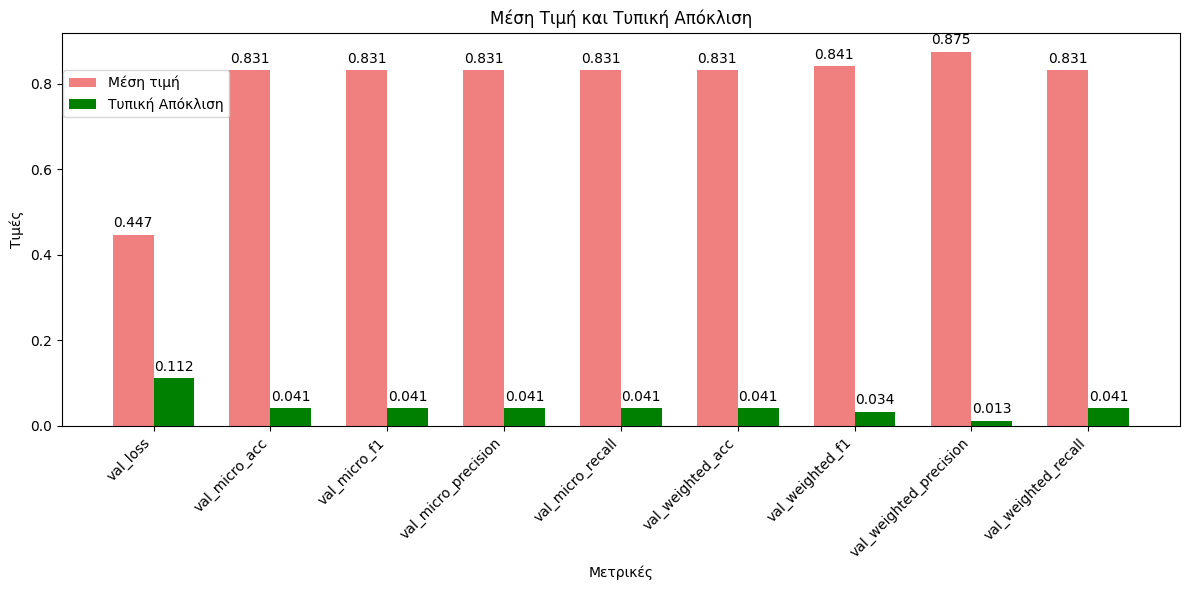

In [ ]:
metrics = list(mean_results.keys())
mean_values = list(mean_results.values())
std_values = list(std_results.values())

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, mean_values, width, label='Μέση τιμή', color='lightcoral')
rects2 = ax.bar(x + width/2, std_values, width, label='Τυπική Απόκλιση', color='green')

ax.set_xlabel('Μετρικές')
ax.set_ylabel('Τιμές')
ax.set_title('Μέση Τιμή και Τυπική Απόκλιση')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(-0.005,0.922))

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()

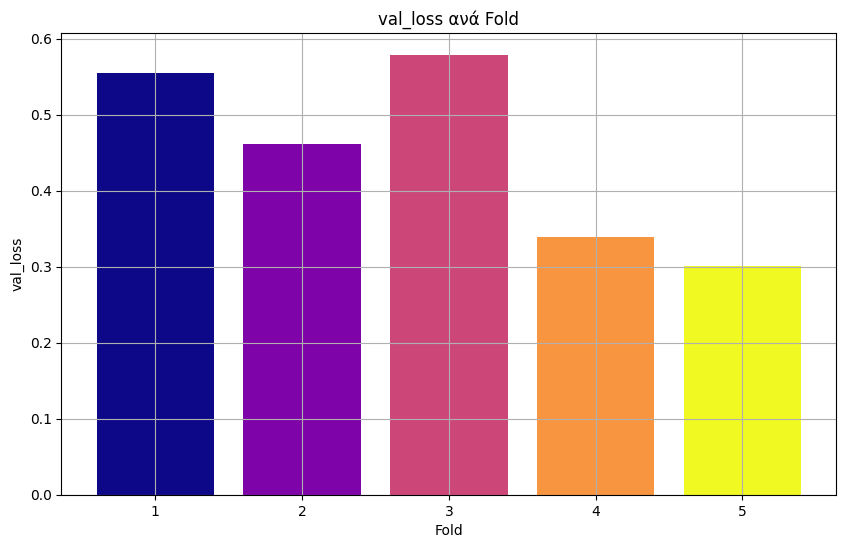

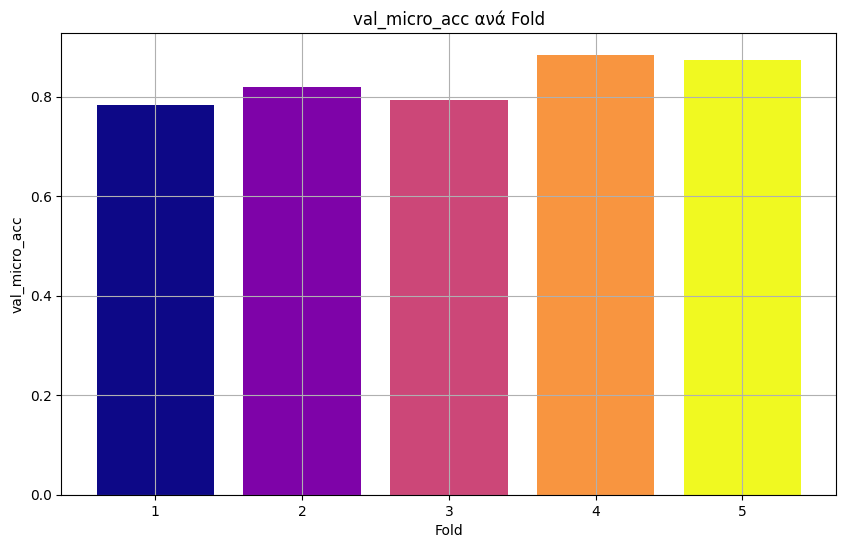

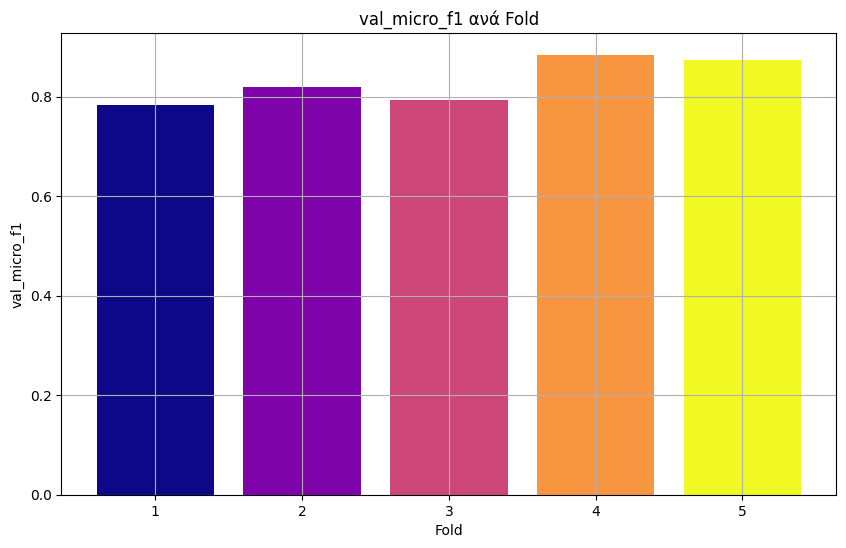

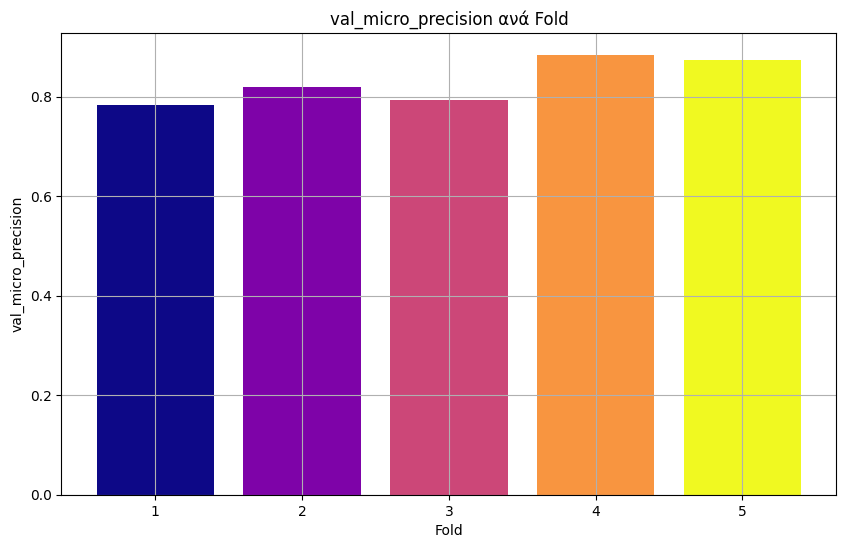

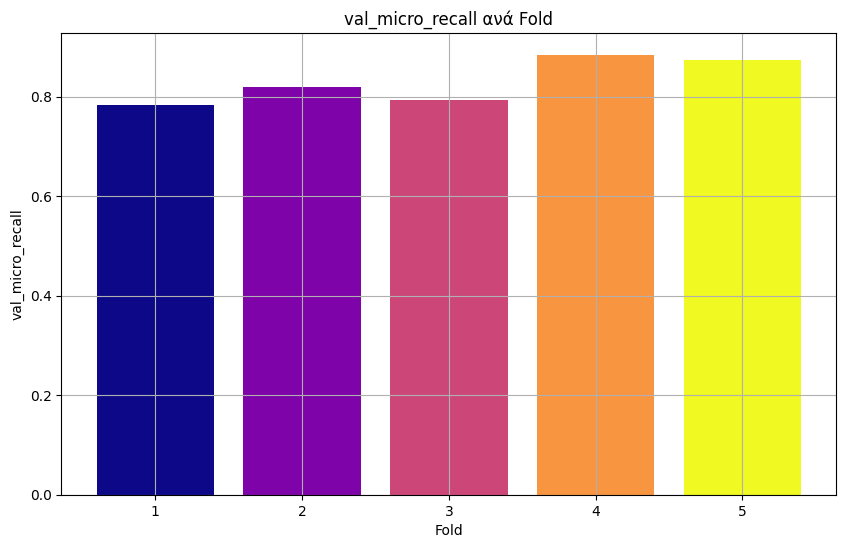

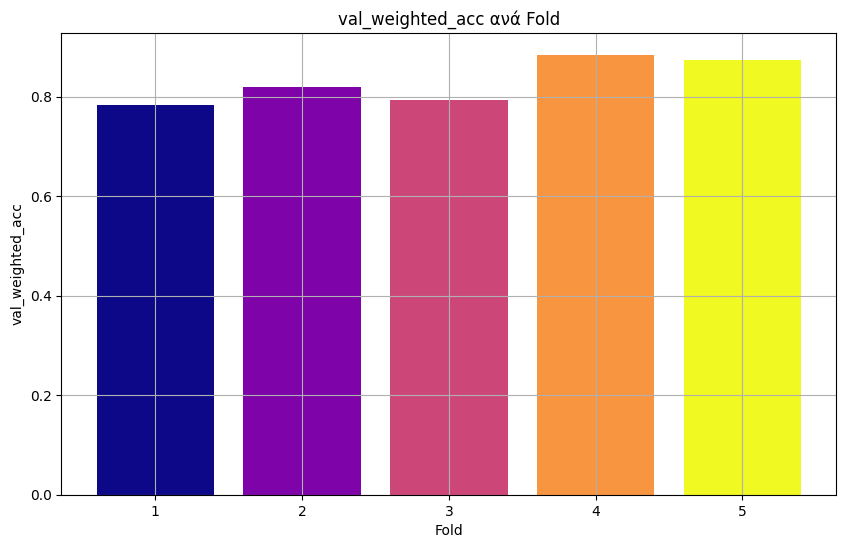

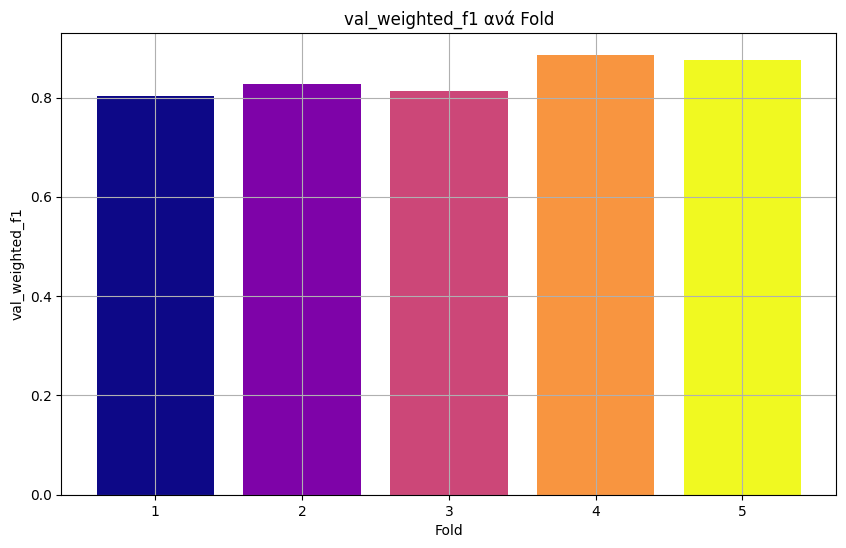

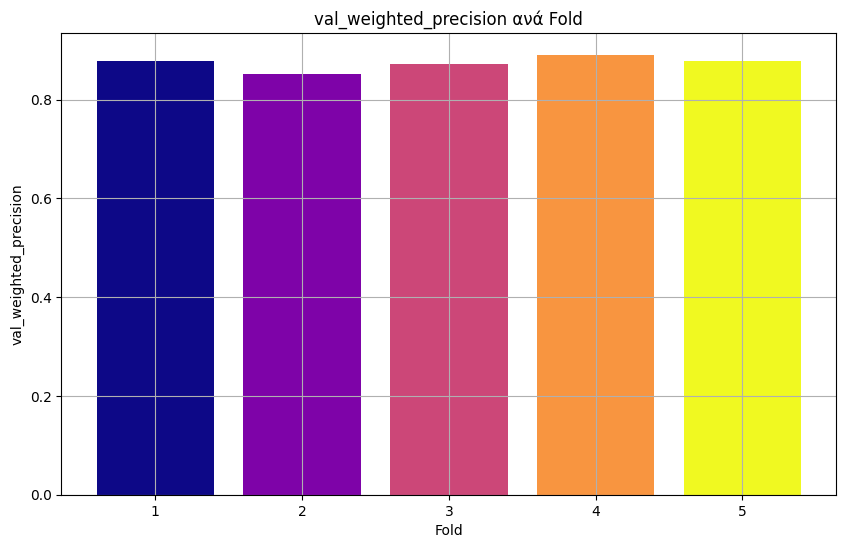

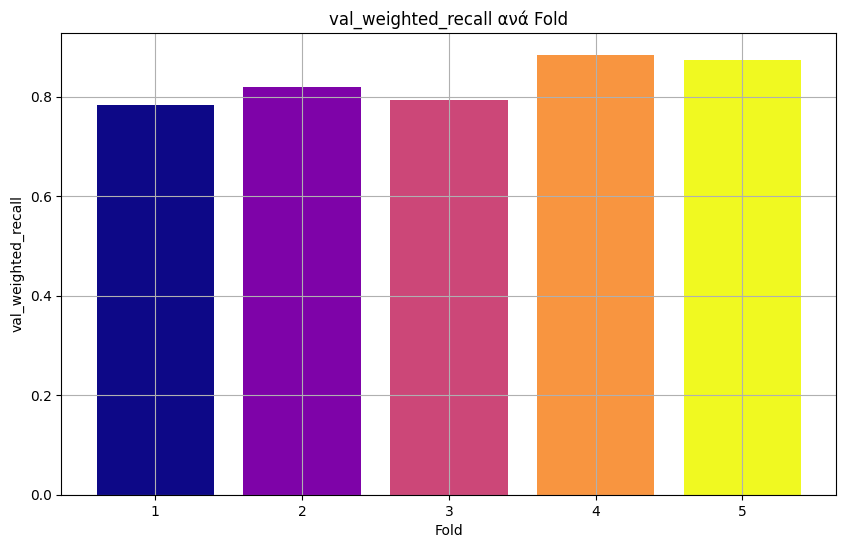

In [ ]:
folds = list(range(1, len(best_results) + 1))
colors = plt.cm.plasma(np.linspace(0, 1, len(folds)))

for metric in metrics:
    plt.figure(figsize=(10, 6))
    values = [result[metric] for result in best_results]
    plt.bar(folds, values, color=colors)
    plt.title(f'{metric} ανά Fold')
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.xticks(folds)
    plt.grid(True)
    plt.show()

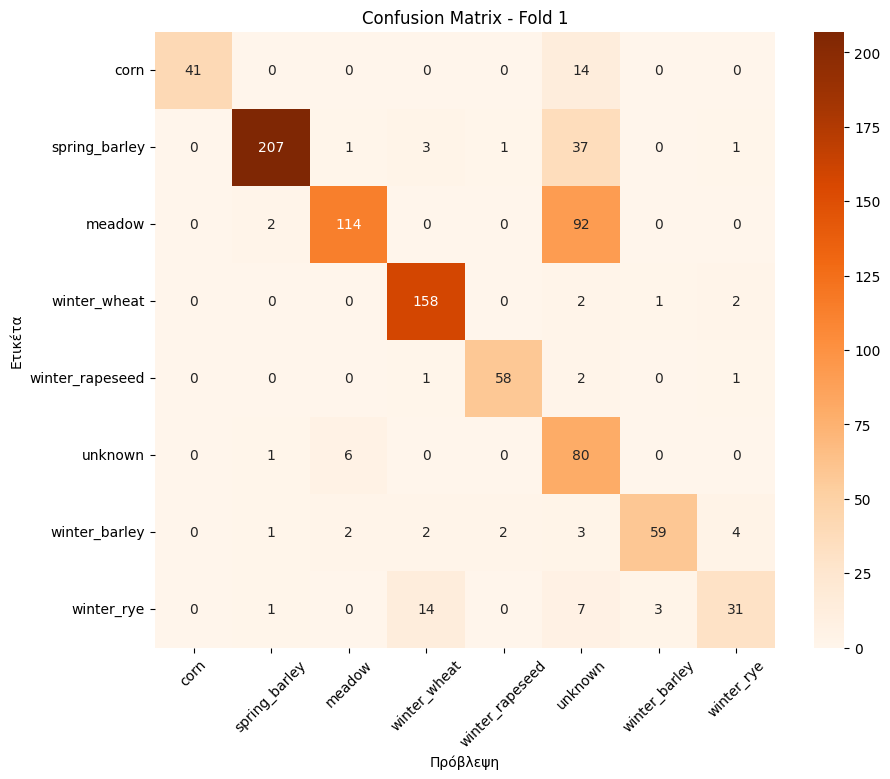

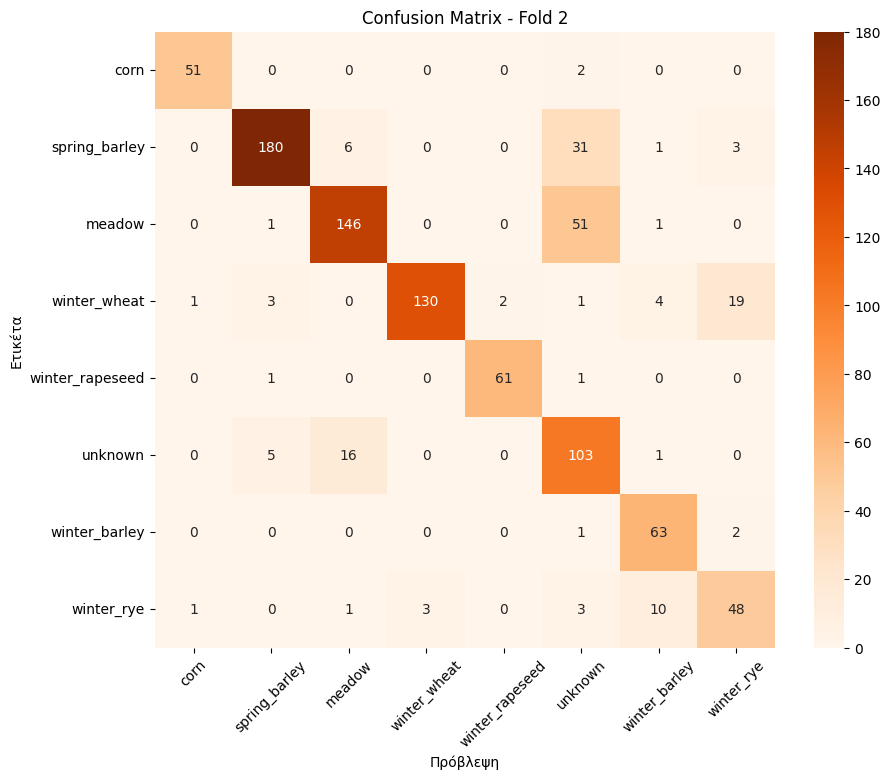

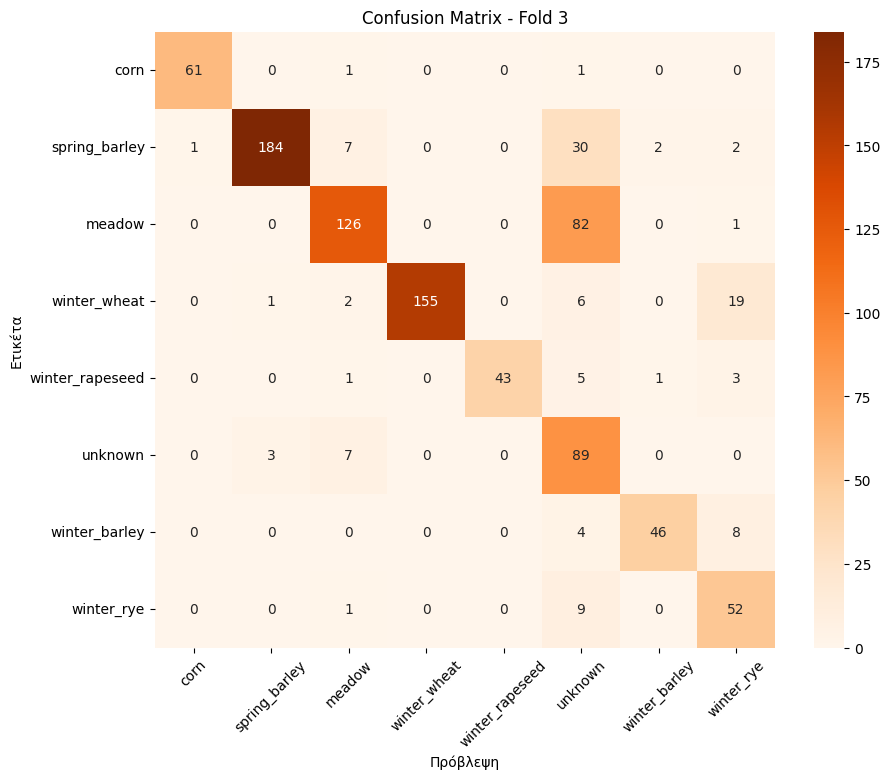

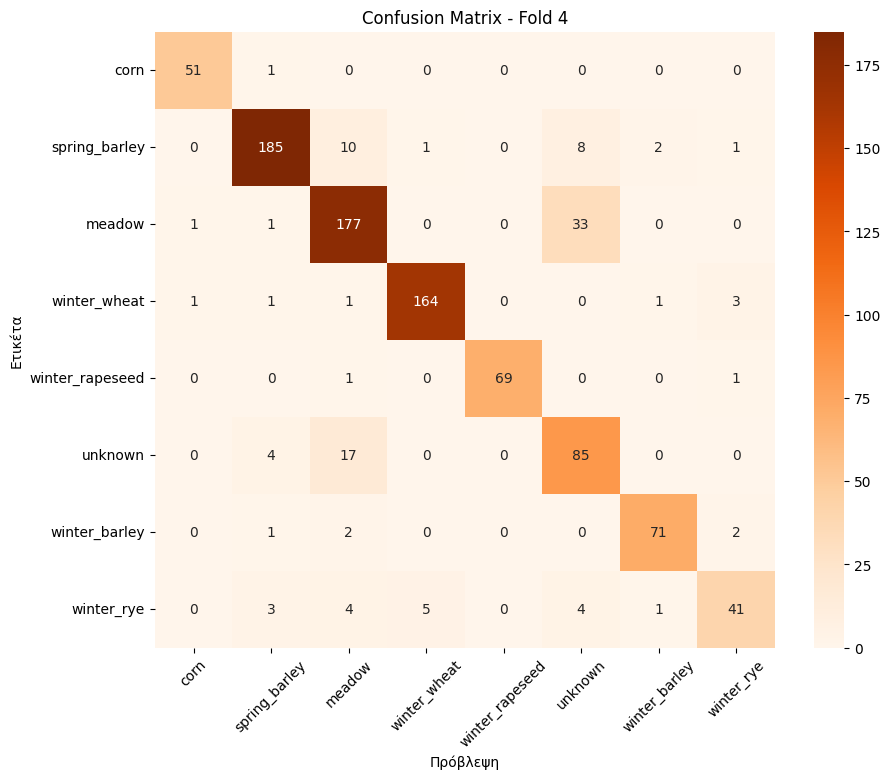

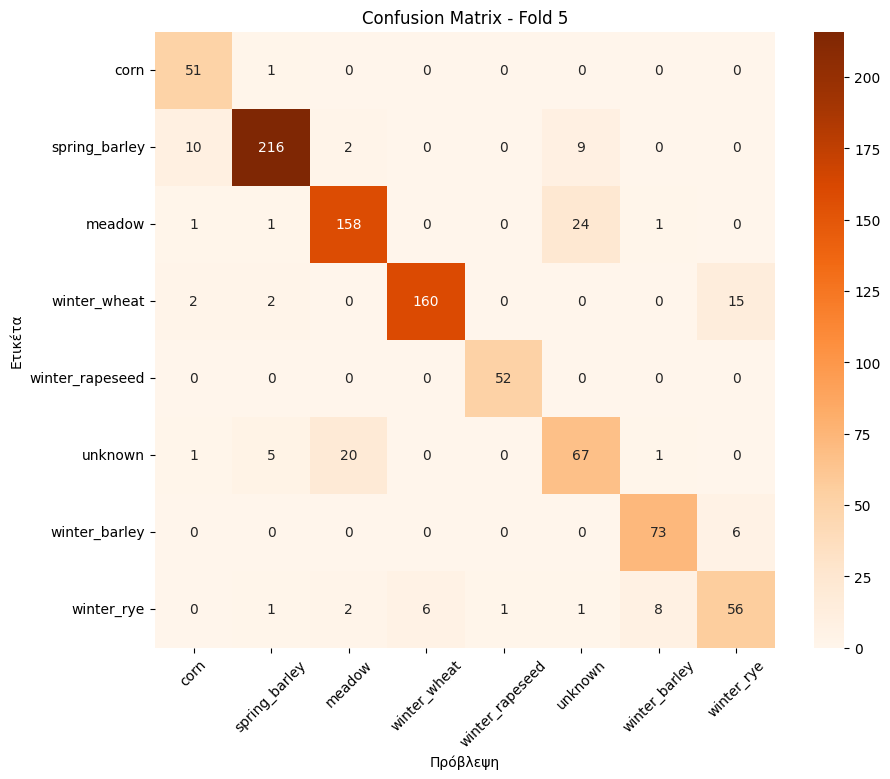

In [ ]:
class_names = list(filtered_labels_ni.keys())

for fold, conf_matrix in enumerate(best_confusion_matrices):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Πρόβλεψη')
    plt.xticks(rotation=45)
    plt.ylabel('Ετικέτα')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()
